## Dataset and Utility Setup

In [59]:
import tensorflow as tf

from data_paths import data_paths, data_config
from utils.dataset_utils import AudioData
from models.unet.unet_wrapped import AmpDbSpectLayer, AmpDbToAudioLayer, STFTLayer, ISTFTLayer
from utils.spectrogram_utils import SpectUtils
from models.unet.unet import OurUNet
from models.unet.test_unet_spec import model_spec
import tensorflow_io as tfio

In [10]:
train_data = tf.data.Dataset.load(data_paths["spectrograms"]["train"])
test_data = tf.data.Dataset.load(data_paths["spectrograms"]["test"])

In [11]:
spectutils = SpectUtils(
    sampling_rate=data_config["sample_rate"],
    hop_length=data_config["hop_length"],
    frame_length=data_config["frame_length"],
    fft_length=data_config["fft_length"]
)

stft_config = {
    "hop_length" : data_config["hop_length"],
    "noise_level" : data_config["noise_level"],
    "frame_length" : data_config["frame_length"],
    "fft_length" : data_config["fft_length"],
    "window_func" : tf.signal.hann_window
}

stft_config_str = {
    "hop_length" : data_config["hop_length"],
    "noise_level" : data_config["noise_level"],
    "frame_length" : data_config["frame_length"],
    "fft_length" : data_config["fft_length"],
    "window_func" : "Hann Window"
}

In [18]:
mixed_ex_spect = None
clean_ex_spect = None
for mixed_spect, clean_spect in train_data.take(1):
    mixed_ex_spect = mixed_spect
    clean_ex_spect = clean_spect

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example mixed spectrogram'}, xlabel='Time'>)

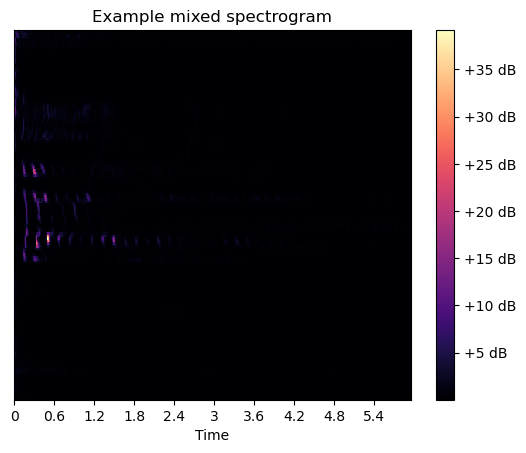

In [19]:
spectutils.display_intensity_spectrogram(mixed_ex_spect, "Example mixed spectrogram")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example clean spectrogram'}, xlabel='Time'>)

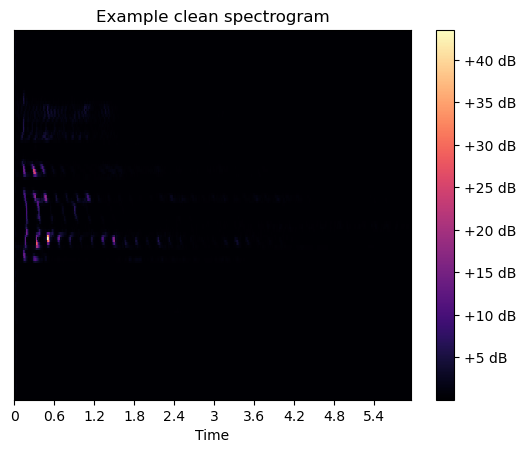

In [20]:
spectutils.display_intensity_spectrogram(clean_ex_spect, "Example clean spectrogram")

In [21]:
amp_spect_to_audio = AmpDbToAudioLayer(
    stft_config=stft_config,
    dB=False
)

In [23]:
recov_clean = amp_spect_to_audio(clean_ex_spect)

In [24]:
recov_mixed = amp_spect_to_audio(mixed_ex_spect)

In [25]:
spectutils.save_numpy_as_wav(recov_clean, "./example_clean_recovered_no_unet.wav")
spectutils.save_numpy_as_wav(recov_mixed, "./example_mixed_recovered_no_unet.wav")

# Model: One Epoch

For this run, the model was trained for a single epoch using Adam at a learning rate of 1/10th Adam's default in Keras: 0.0001. Details about the specifics of the short-time Fourier transform are below.

In [58]:
import json

In [64]:
print(json.dumps(data_config, indent=4))

{
    "data_folder_path": "./data",
    "folder_name": "MS-SNSD",
    "sample_rate": 16000,
    "hop_length": 256,
    "noise_level": 0.1,
    "frame_length": 1024,
    "fft_length": 1024,
    "clean_vec_repeats": 1
}


In [51]:
import pickle

The history for this training session was lost due to an error in file paths (the model weights saved over the history object). However, this would have been a rather uninteresting history: there was only one epoch!

In [29]:
# Loading a blank model
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)

In [30]:
# Verifying that the blank model was loaded
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   160         ['input_1[0][0]']                
                                16)                                                               
                                                                                                  
 dropout (Dropout)              (None, None, None,   0           ['conv2d[0][0]']                 
                                16)                                                           

In [33]:
unet.load_weights("/home/spandan/projects_new/audio-denoising-csc487/model_saves/unet01")

In [35]:
mixed_ex_spect.shape

TensorShape([141, 513])

In [41]:
mixed_ex_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_ex_spect, axis=-1), axis=0)

In [42]:
mixed_ex_spect_expanded.shape

TensorShape([1, 141, 513, 1])

In [44]:
prediction_spect = unet.predict(mixed_ex_spect_expanded)

1/1 [==============================] - 0s 108ms/step


In [46]:
prediction_spect_trimmed = tf.squeeze(prediction_spect)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example prediction spectrogram'}, xlabel='Time'>)

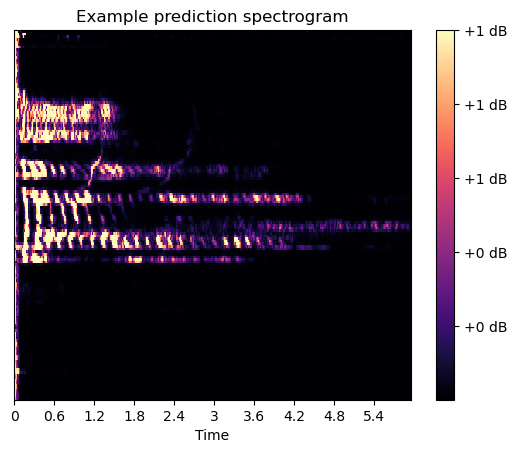

In [47]:
spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Example prediction spectrogram")

In [48]:
predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)

This particular example did not have its noise removed. The human voice is robotic, indicating that phase information was lost during the training process.

In [50]:
spectutils.save_numpy_as_wav(predicted_clean, "./example_prediction.wav")

### Experimentation with Other Audio Clips
We could be running into one of the edge cases: audio clips that are simply too short. Let's try loading a longer audio file, as well as a more prominent noise--in particular, a 13-second clip of a male voice overlaid over a vacuum cleaner.

In [17]:
longer_audio_vect = spectutils.load_into_numpy("data/MS-SNSD/clean_test/clnsp75.wav")
longer_audio_noise = spectutils.load_into_numpy("data/MS-SNSD/noise_test/VacuumCleaner_1.wav")

longer_mixed = spectutils.clean_noise_mixer(
    longer_audio_vect, 
    longer_audio_noise
)

In [66]:
amp_spect_from_audio = AmpDbSpectLayer(stft_config=stft_config, dB=False)
longer_mixed_spect = amp_spect_from_audio(longer_mixed)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Example longer mixed spectrogram'}, xlabel='Time'>)

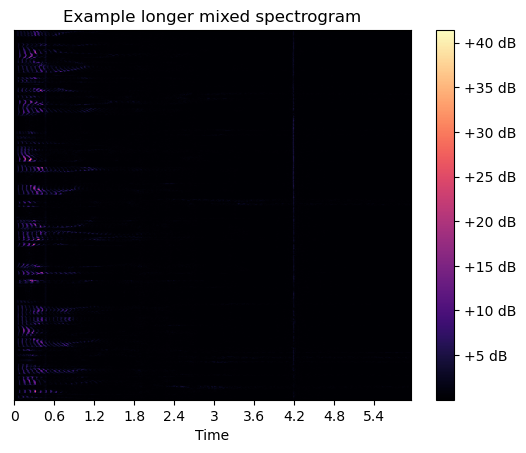

In [68]:
spectutils.display_intensity_spectrogram(longer_mixed_spect, "Example longer mixed spectrogram")

Here's a prediction function that handles all of the dimensional oddities and accepts any UNet for a prediction:

In [74]:
def predict_on_using(mixed_spect, unet, path):
    mixed_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_spect, axis=-1), axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Prediction spectrogram")
    predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

In [76]:
spectutils.save_numpy_as_wav(longer_mixed, "./unet01_longer_prediction_mixed.wav")

1/1 [==============================] - 0s 441ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 9.5204393e-11, 4.0860620e-11, ..., 4.5123492e-08,
       2.2448559e-08, 6.1386802e-09], dtype=float32)>

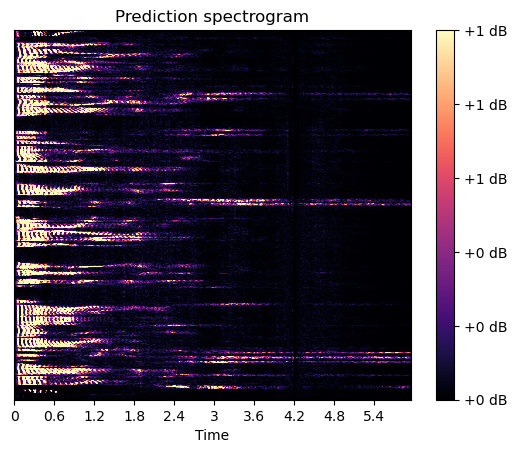

In [75]:
predict_on_using(longer_mixed_spect, unet, "./unet01_longer_prediction.wav")

The voice remains *terribly* robotic, indicating loss of phase information again. Applying the Griffin-Lim algorithm to a result of a UNet doesn't seem to work well, and this is, in fact, somewhat intuitive: even the smallest local disturbances can *entirely* destroy phase information, to a point beyond recovery by the Griffin-Lim algorithm.

### More Epochs?

First, we can try training for as many epochs as early stopping will allow. I set the target epoch number to be 10. With this configuration, early stopping triggers after epoch 3. Something interesting is that MAE values *do* continue to improve; this may suggest that it's beneficial to remove early stopping and see where training for a ludicrous number of epochs takes us.

In [80]:
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)
unet.load_weights("./model_saves/unet10")

1/1 [==============================] - 0s 299ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 2.0995822e-10, 4.8096488e-10, ..., 5.1129721e-08,
       2.2022936e-08, 5.2410978e-09], dtype=float32)>

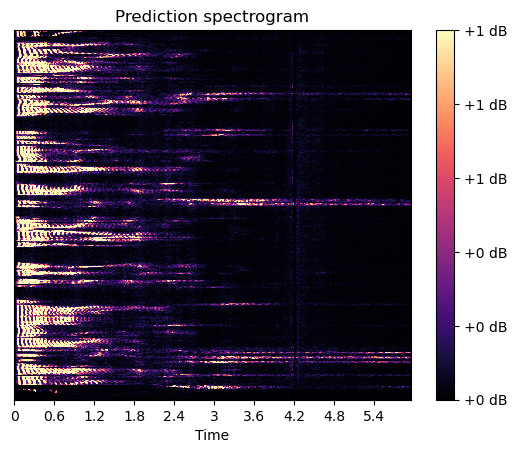

In [92]:
predict_on_using(longer_mixed_spect, unet, "./unet03_longer_prediction.wav")

Only *slightly* more noise was removed. Phase information still remains destroyed. To ensure this is not just due to a misimplementation of the Griffin-Lim algorithm, we can try running Griffin-Lim on just the mixed spectrogram:

In [82]:
recovered_longer_mixed_spect_no_net = amp_spect_to_audio(longer_mixed_spect)
spectutils.save_numpy_as_wav(recovered_longer_mixed_spect_no_net, "./longer_mixed_no_net.wav")

Unfortunately, it sounds like the issue is absolutely our model--and *not* a shortcoming of phase approximation methods. It makes sense that the network would not aim to approximate phases well; there was no information in the labels that made this clear! The model was simply provided an amplitude spectrogram and told to learn the mapping, without explicitly being asked to capture phase details of the training label.

We can try bumping up the iteractions of the Griffin-Lim algorithm.

In [87]:
class AmpDbToAudioLayerMoreIters(tf.keras.layers.Layer):
    def __init__(self, stft_config, dB = False, halve = False, iters = 30):
        super(AmpDbToAudioLayerMoreIters, self).__init__()
        self.stft_config = stft_config
        self.dB = dB
        self.iters = iters
        self.halve = halve
    
    def call(self, inputs, *args, **kwargs):
        # super.__call__(args, kwargs) # TODO: correct?

        if(self.dB):
            inputs = _db_to_amp_tensorflow(inputs)
        
        if(self.halve):
            inputs = 0.5 * inputs

        # TODO: remove 0.5?
        # TODO: params could be different
        output = tfio.audio.inverse_spectrogram(
            spectrogram=inputs,
            nfft=self.stft_config["fft_length"],
            window=self.stft_config["frame_length"],
            stride=self.stft_config["hop_length"],
            iterations=self.iters
        )

        return output

In [88]:
def predict_on_using_more_iters(mixed_spect, unet, path):
    amp_spect_to_audio = AmpDbToAudioLayerMoreIters(
        stft_config=stft_config,
        dB = False,
        iters=100
    )
    mixed_spect_expanded = tf.expand_dims(tf.expand_dims(mixed_spect, axis=-1), axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    spectutils.display_intensity_spectrogram(prediction_spect_trimmed, "Prediction spectrogram")
    predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

1/1 [==============================] - 0s 231ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 7.9606183e-11, 3.8887910e-10, ..., 3.7767432e-08,
       1.8777476e-08, 4.8075655e-09], dtype=float32)>

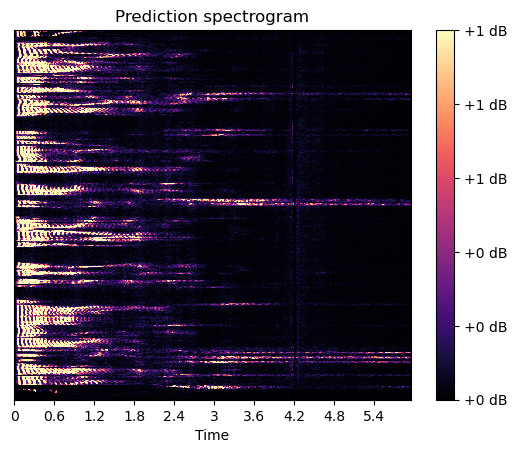

In [94]:
predict_on_using_more_iters(longer_mixed_spect, unet, "./unet03_longer_prediction_more_gl_iters.wav")

This produces VERY *slight* clarity improvement. 

In [95]:
unetbuilder = OurUNet()
unet = unetbuilder.build_model(modelspec=model_spec)
unet.load_weights("./model_saves/unet10/unet10")

1/1 [==============================] - 0s 407ms/step


<tf.Tensor: shape=(210944,), dtype=float32, numpy=
array([0.0000000e+00, 8.2099322e-10, 1.8590076e-09, ..., 7.8972446e-09,
       3.1690481e-09, 1.1103136e-09], dtype=float32)>

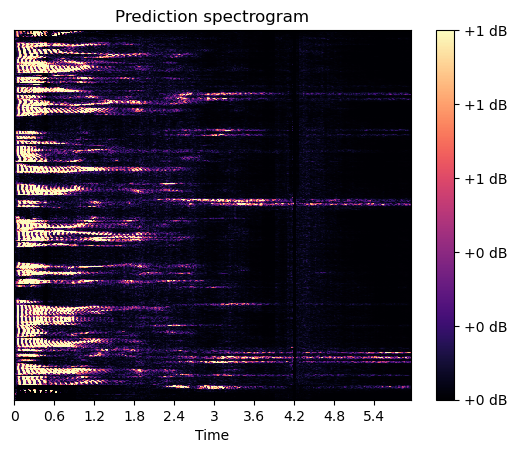

In [96]:
predict_on_using_more_iters(longer_mixed_spect, unet, "./unet03_longer_prediction_more_gl_iters_folder.wav")

## Trying Complex Inputs

Before we train a model using complex inputs, we would like to try and bring a complex spectrogram back to audio to determine whether we can do so (without the added obstacle of the model's edits).

In [15]:
stft = STFTLayer(stft_config=stft_config)
istft = ISTFTLayer(stft_config=stft_config)

In [19]:
complex_spect = stft(longer_mixed)

In [20]:
real_component = tf.math.real(complex_spect)
imag_component = tf.math.imag(complex_spect)

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Real component'}, xlabel='Time'>)

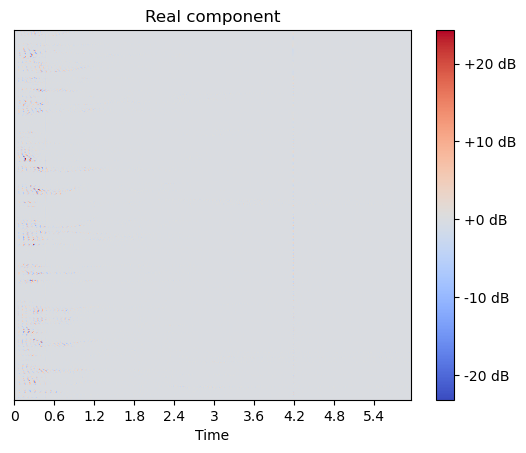

In [21]:
spectutils.display_intensity_spectrogram(real_component, "Real component")

(<Figure size 640x480 with 2 Axes>,
 <Axes: title={'center': 'Imaginary component'}, xlabel='Time'>)

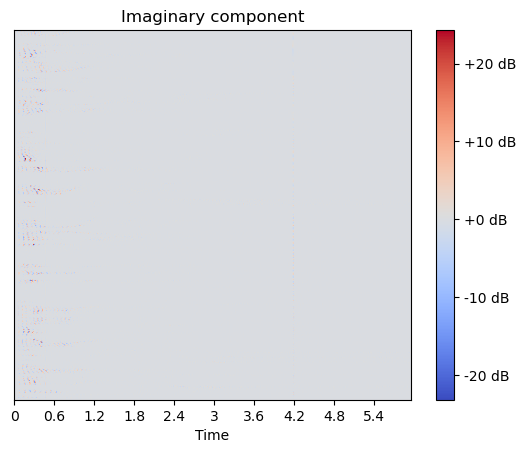

In [22]:
spectutils.display_intensity_spectrogram(real_component, "Imaginary component")

In [23]:
recovered_from_complex = istft(complex_spect)
spectutils.save_numpy_as_wav(recovered_from_complex, "./recovered_from_unseparated_complex.wav")

This recovery works. Let's try recovering from the SEPARATED components.

In [24]:
recovered_from_sep_complex = istft(tf.dtypes.complex(real_component, imag_component))
spectutils.save_numpy_as_wav(recovered_from_sep_complex, "./recovered_from_separated_complex.wav")

This recovery also works! We can now attempt to provide the model two-channel input.

Tensors can be stacked to produce two-channel (2 in the *final* component) inputs:

In [25]:
teststack = tf.expand_dims(tf.stack([real_component, imag_component], -1), axis=0)
teststack.shape

TensorShape([1, 821, 513, 2])

In [26]:
teststack_trimmed = tf.squeeze(teststack)
teststack_trimmed.shape

TensorShape([821, 513, 2])

In [27]:
teststack_real = teststack_trimmed[:, :, 0]
teststack_imag = teststack_trimmed[:, :, 1]

In [28]:
teststack_real.shape

TensorShape([821, 513])

The spectrograms and their labels now have two channels!


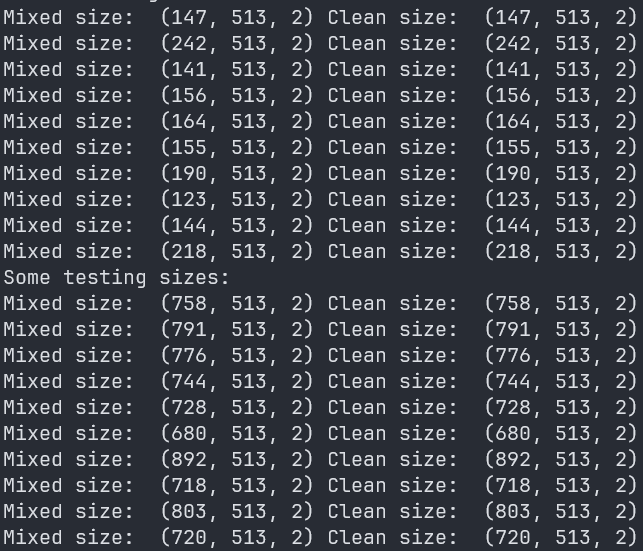

The unet definition in models/unet was adapted to unet_complex, a unet that takes in two-channel 2D tensors. The Adam optimizer's learning rate was maintained at 0.0001, and all other settings were not changed. This training round exhibited lower MSE loss values (for all previous runs, loss values stablized at 1.2--this time, they began at around 0.8 and decreased steadily).

The most obvious thing lacking from the amplitude-only network was phase information. Hopefully, that is maintained here.

In [29]:
from models.unet import unet_complex
from models.unet import complex_unet_spec

In [30]:
unet_complex_builder = unet_complex.OurUNet()
unet_complex = unet_complex_builder.build_model(modelspec=complex_unet_spec.model_spec)

The most fundamental change in the following summary is the shift from one-channel inputs (None, None, None, 1) to two-channel inputs (None, None, None, 2).

In [31]:
unet_complex.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, None,  0           []                               
                                 2)]                                                              
                                                                                                  
 conv2d_11 (Conv2D)             (None, None, None,   608         ['input_3[0][0]']                
                                32)                                                               
                                                                                                  
 dropout_5 (Dropout)            (None, None, None,   0           ['conv2d_11[0][0]']              
                                32)                                                         

In [56]:
unet_complex.load_weights("model_saves/unet_complex/unet_complex")

In [33]:
def predict_on_using_complex(complex_spect, unet, path):
    real = tf.math.real(complex_spect)
    imag = tf.math.imag(complex_spect)
    dual_channel = tf.stack([real, imag], -1)
    mixed_spect_expanded = tf.expand_dims(dual_channel, axis=0)
    prediction_spect = unet.predict(mixed_spect_expanded)
    prediction_spect_trimmed = tf.squeeze(prediction_spect)
    prediction_spect_real = prediction_spect_trimmed[:, :, 0]
    prediction_spect_imag = prediction_spect_trimmed[:, :, 1]
    spectutils.display_intensity_spectrogram(prediction_spect_real, "Prediction spectrogram, real")
    spectutils.display_intensity_spectrogram(prediction_spect_imag, "Prediction spectrogram, imaginary")
    predicted_clean = istft(tf.dtypes.complex(prediction_spect_real, prediction_spect_imag))
    # predicted_clean = amp_spect_to_audio(prediction_spect_trimmed)
    spectutils.save_numpy_as_wav(predicted_clean, path)
    return predicted_clean

1/1 [==============================] - 1s 711ms/step


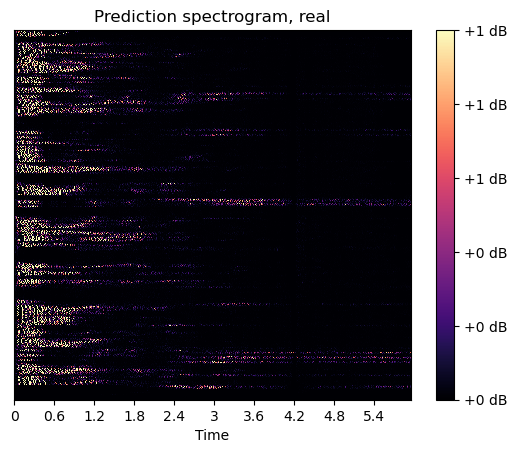

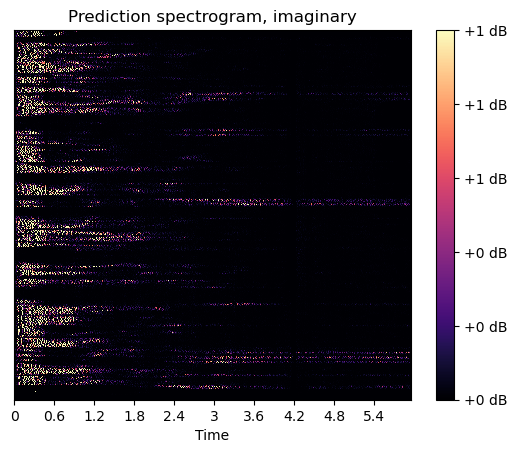

In [34]:
complex_prediction = predict_on_using_complex(complex_spect, unet_complex, "./complex_prediction.wav")

This is the point where we **almost entirely** accomplished what we set out to do! There is *no* vacuum cleaner noise in the background of the audio clip generated from the above prediction--and the voice is non-robotic, with phase information preserved! The voice does sound slightly nasal, but this can presumably be rectified by tweaking specifics about model hyperparameters.

Although we hypothesized that the Griffin-Lim algorithm paired with the detail-preservation properties of the UNet's filter store would be enough to retain or recover phase information, it appears we were mistaken; using real and complex channels greatly outperforms the amplitude-then-phase-recovery method.

Here are some problem points that exist in this state of the model, and how we might address them: 
- The beginning of the audio clip is being cut off. This is quite difficult to prevent, as the short time Fourier transform is inherently convolution-like and reduces the resolution of its input vector/matrix--in particular, at the edges.
- The voice sounds slightly nasal, with a higher frequency and perhaps a smaller frequency range than the original voice contained. We can think of some complex solutions to this issue: perhaps create a classifier for high-frequency and low-frequency voices and train two models--one specializing in each?  

## Test Cases

In [35]:
import os

In [48]:
def test_case(clean_wav_path, noise_wav_path, unet, test_case_dir_path):
    # Loads the .wav files as NumPy vectors
    clean_vec = spectutils.load_into_numpy(clean_wav_path)
    noise_vec = spectutils.load_into_numpy(noise_wav_path)

    # Generates a mixed vector at noise level 0.1
    mixed_vec = spectutils.clean_noise_mixer(clean_vec, noise_vec, noise_level=0.1)

    # Obtains paths in a test case directory for the clean audio, noise audio,
    # and prediction audio
    clean_path = os.path.join(test_case_dir_path, "clean_audio.wav")
    noise_path = os.path.join(test_case_dir_path, "noise_audio.wav")
    mixed_path = os.path.join(test_case_dir_path, "mixed_audio.wav")
    prediction_path = os.path.join(test_case_dir_path, "prediction.wav")

    # Obtains the mixed spectrogram that is the input to the complex UNet
    complex_spect = stft(mixed_vec)

    # Obtains the UNet's prediction and saves it as a .wav in the test directory
    predicted_clean = predict_on_using_complex(complex_spect, unet, prediction_path)
    
    # Saves the post-NumPy clean and noise audio as a reference, in the test directory
    spectutils.save_numpy_as_wav(clean_vec, clean_path)
    spectutils.save_numpy_as_wav(noise_vec, noise_path)
    spectutils.save_numpy_as_wav(mixed_vec, mixed_path)

1/1 [==============================] - 1s 623ms/step


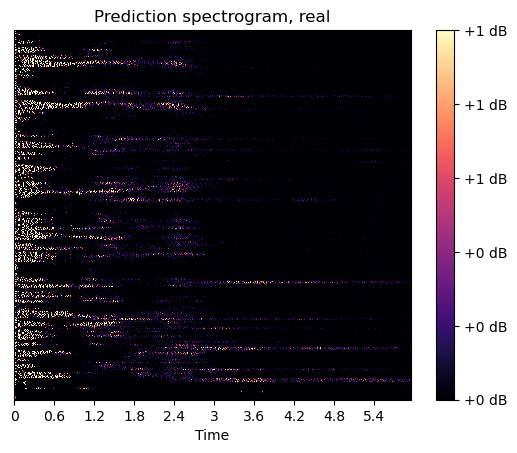

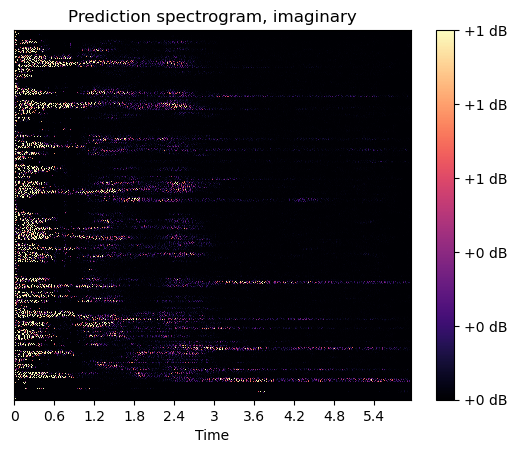

In [50]:
test_case(
    "data/MS-SNSD/clean_test/clnsp23.wav",
    "data/MS-SNSD/noise_test/AirConditioner_4.wav",
    unet_complex,
    "test_cases/test01"
)

This test case involves a male voice and an air conditioner. The result does sound slightly robotic.

1/1 [==============================] - 1s 715ms/step


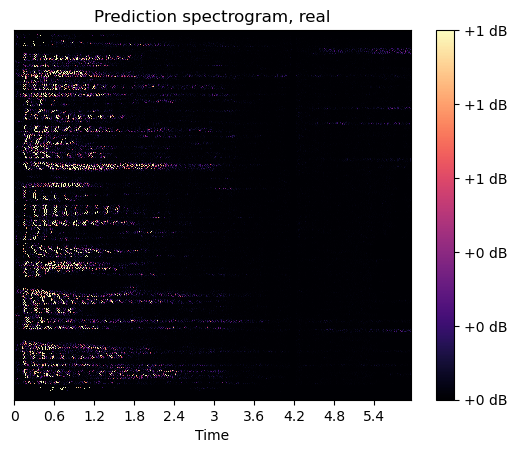

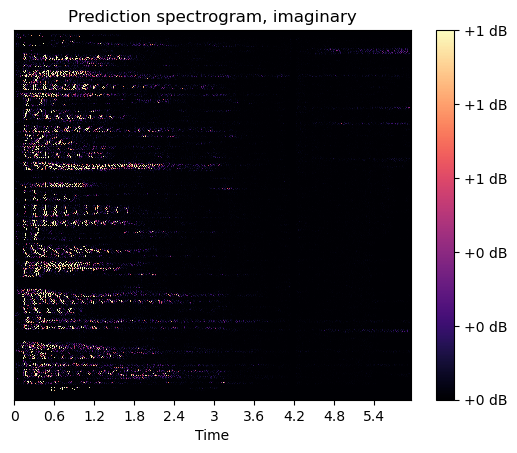

In [57]:
test_case(
    "data/MS-SNSD/clean_test/clnsp41.wav",
    "data/MS-SNSD/noise_test/VacuumCleaner_1.wav",
    unet_complex,
    "test_cases/test02"
)

This example involves a female voice and a vacuum cleaner. At high-intensity points in the speech signal, the vacuum cleaner noise makes it through--suggesting (intuitively) that the model has difficulties with signals and noises that are close to each other in frequency.

1/1 [==============================] - 1s 712ms/step


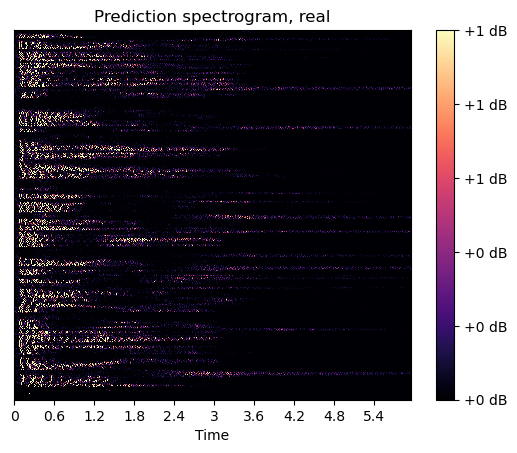

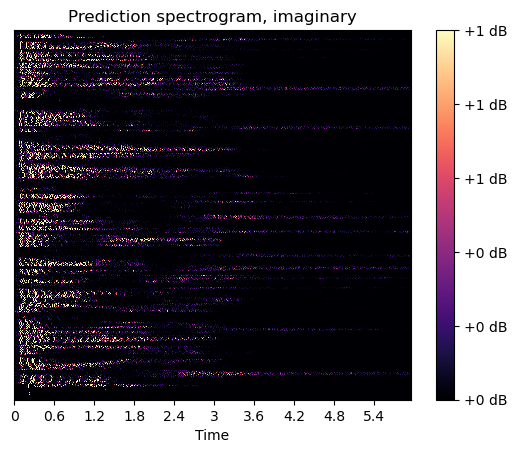

In [52]:
test_case(
    "data/MS-SNSD/clean_test/clnsp109.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex,
    "test_cases/test03"
)

This test case was a noteworthy edge case: one in which the signal and noise are both human voices. A *lot* of the signal gets cut out--suggesting that the model is having a difficult time finding the separation between signal and noise. It is still on the well-performing side, however: it cuts out too much of the signal, but successfully removes most of the noise. This was surprising for us; we were sure this case would fail terribly.

1/1 [==============================] - 1s 743ms/step


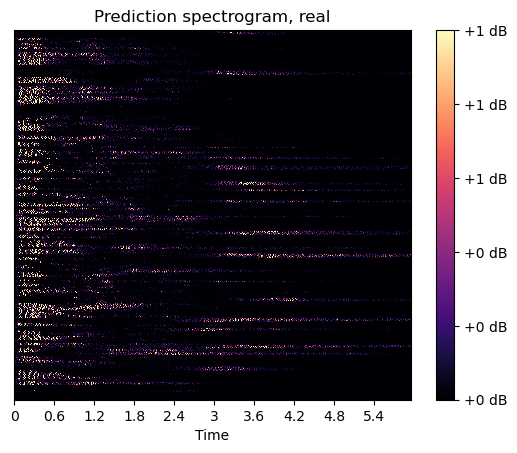

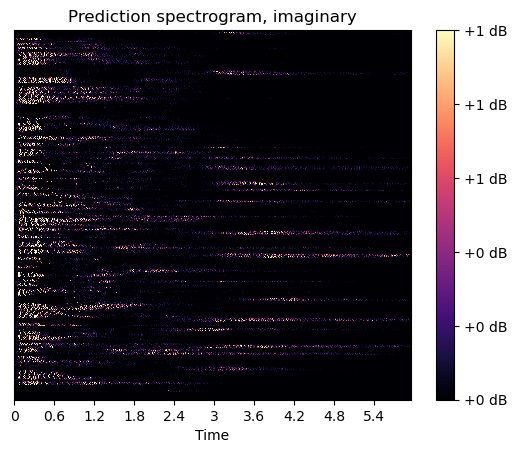

In [53]:
test_case(
    "data/MS-SNSD/clean_test/clnsp886.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex,
    "test_cases/test04"
)

This test case is meant to produce a difficult human-signal human-noise case; the noise is the same as the last one (overlapping human voices), but a voice was chosen that gets a little closer to the frequency of a voice within the background chatter.

1/1 [==============================] - 1s 753ms/step


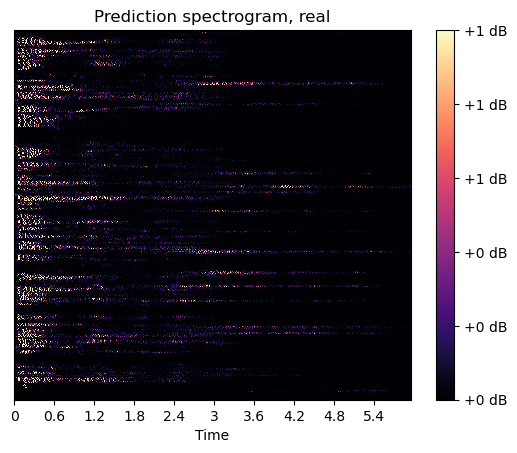

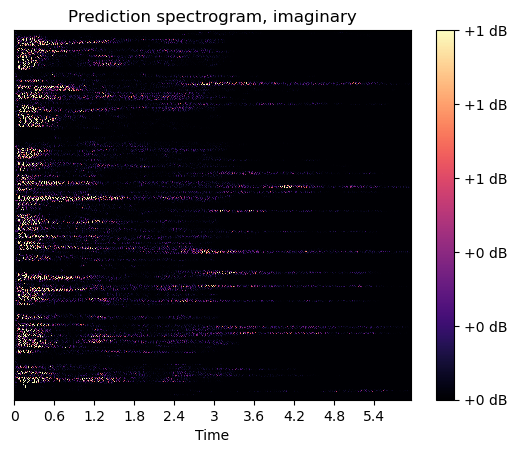

In [54]:
test_case(
    "data/MS-SNSD/clean_test/clnsp0.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex,
    "test_cases/test05"
)

This test case continues the pattern from the last one; a low-frequency signal voice is chosen to try and cause conflict with the low-frequency voice in the background chatter. There is some notable difficulty; the signal voice drops out quite often, and only a higher-frequency, nasal version is retained. 

1/1 [==============================] - 0s 129ms/step


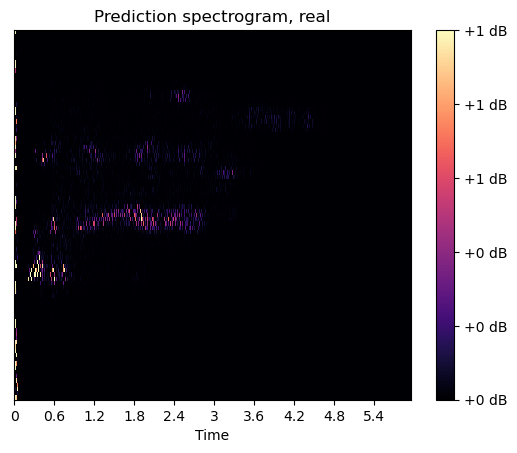

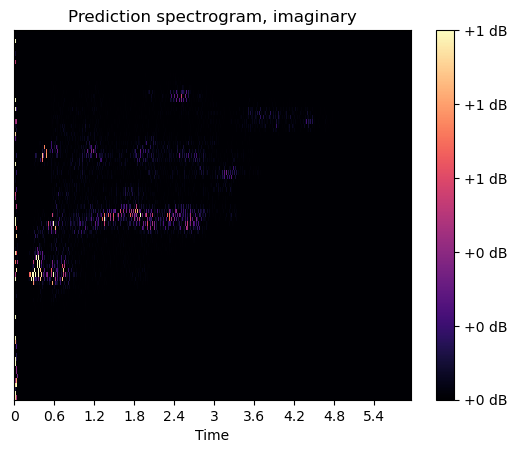

In [55]:
test_case(
    "short_clean.wav",
    "data/MS-SNSD/noise_test/AirConditioner_9.wav",
    unet_complex,
    "test_cases/test06"
)

This is a particularly aggressive example: the sample rate is not the same one the model was trained with (16hz) and it's much shorter than the ~10-15 second clips in the MS-SNSD training and testing sets. Regardless, it performs decently--despite some signal quieting.

## Test Cases - More Epochs

In [61]:
from models.unet import unet_complex
from models.unet import complex_unet_spec

In [62]:
unet_complex_builder_2 = unet_complex.OurUNet()
unet_complex_2 = unet_complex_builder.build_model(modelspec=complex_unet_spec.model_spec)

In [63]:
unet_complex_2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 2)]                                                              
                                                                                                  
 conv2d_22 (Conv2D)             (None, None, None,   608         ['input_4[0][0]']                
                                32)                                                               
                                                                                                  
 dropout_10 (Dropout)           (None, None, None,   0           ['conv2d_22[0][0]']              
                                32)                                                         

In [64]:
unet_complex_2.load_weights("model_saves/unet_complex/unet_complex_2")

1/1 [==============================] - 0s 499ms/step


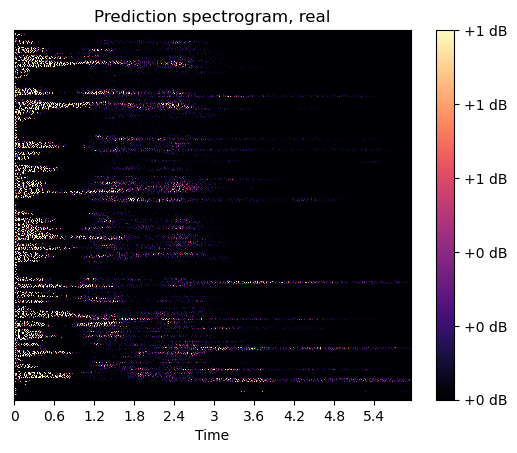

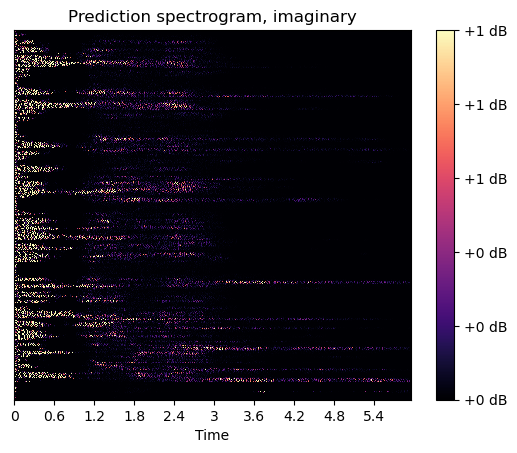

In [66]:
test_case(
    "data/MS-SNSD/clean_test/clnsp23.wav",
    "data/MS-SNSD/noise_test/AirConditioner_4.wav",
    unet_complex_2,
    "test_cases_2/test01"
)

In this case, training for more epochs does not seem to help the nasal nature of the prediction. There is considerably less white noise from the air conditioner however!

1/1 [==============================] - 1s 853ms/step


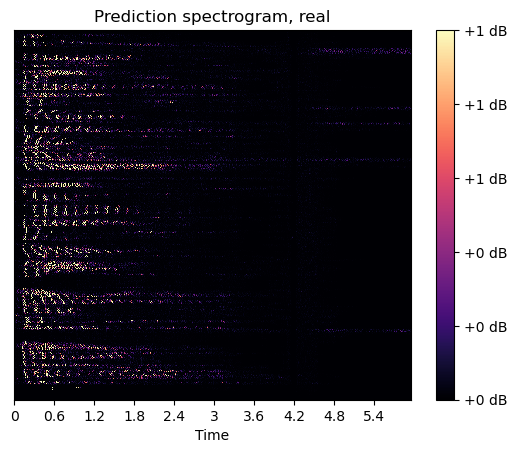

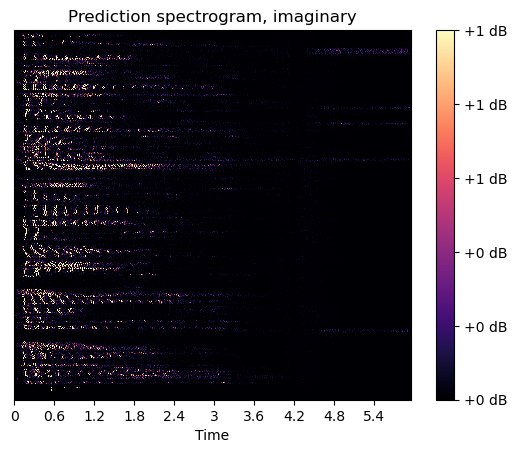

In [67]:
test_case(
    "data/MS-SNSD/clean_test/clnsp41.wav",
    "data/MS-SNSD/noise_test/VacuumCleaner_1.wav",
    unet_complex_2,
    "test_cases_2/test02"
)

More training *did* help with the entrance of the vacuum cleaner at every intensity peak of the speech signal; however, it is still quite noticeable. Of course, as for all of these, the overall audio quality could be better.

1/1 [==============================] - 1s 642ms/step


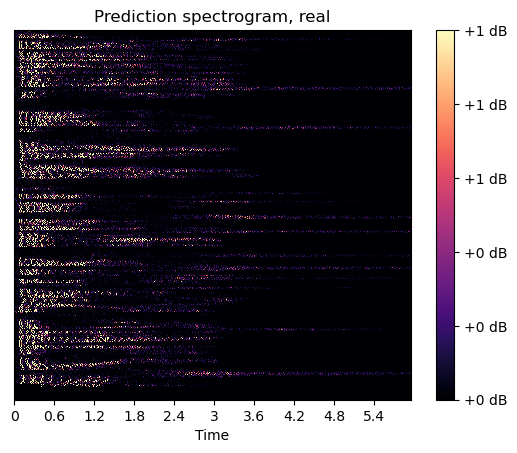

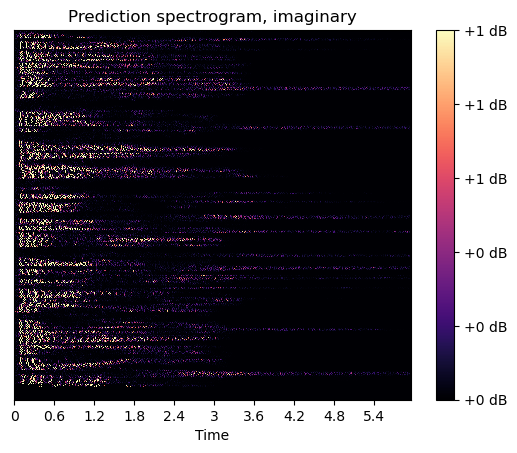

In [68]:
test_case(
    "data/MS-SNSD/clean_test/clnsp109.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex_2,
    "test_cases_2/test03"
)

There aren't many qualitative differences between this case and the case using the less-trained model. The range of signal frequencies is still much narrower, with a slight apparent loss of phase information (resulting in a slightly robotic voice).

1/1 [==============================] - 1s 683ms/step


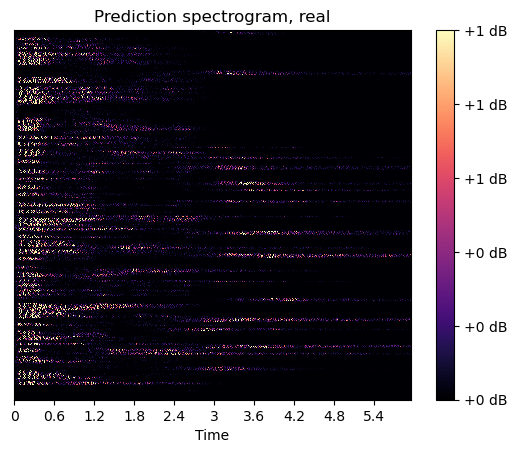

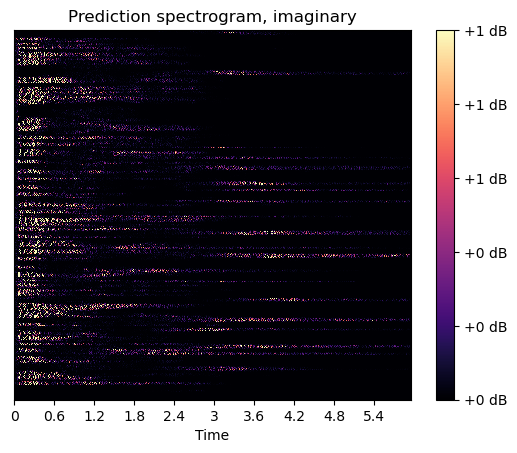

In [69]:
test_case(
    "data/MS-SNSD/clean_test/clnsp886.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex_2,
    "test_cases_2/test04"
)

Once again (and just like this test case with the previous model), the range of signal frequencies is quite compressed. 

1/1 [==============================] - 1s 707ms/step


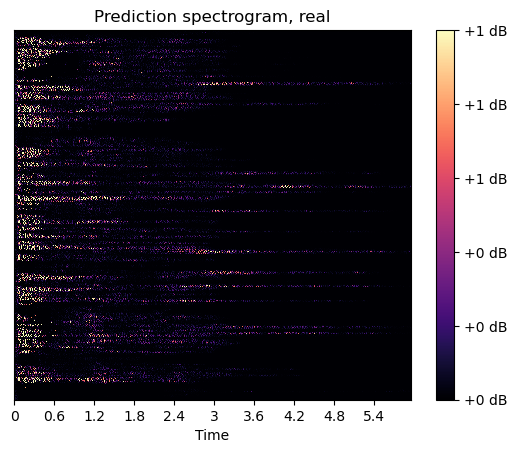

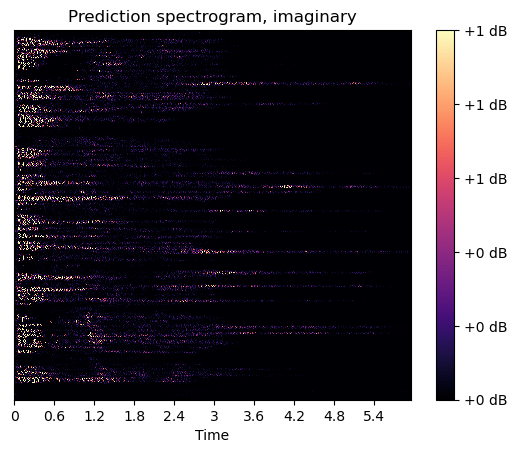

In [71]:
test_case(
    "data/MS-SNSD/clean_test/clnsp0.wav",
    "data/MS-SNSD/noise_train/Babble_8.wav",
    unet_complex_2,
    "test_cases_2/test05"
)

In this case, it seems that the single-epoch model maintains more signal information! It appears that the more the model is trained, the higher of a tendency it has to compress signal frequencies. 

1/1 [==============================] - 0s 167ms/step


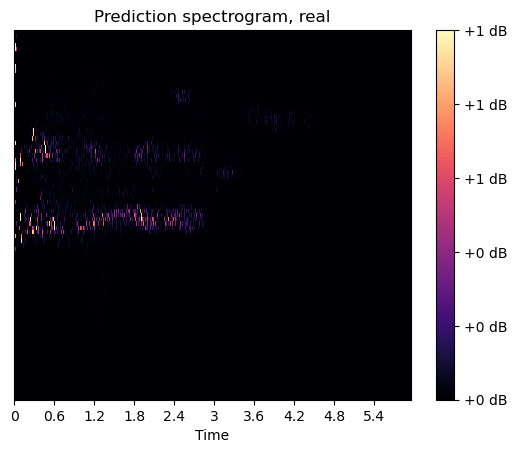

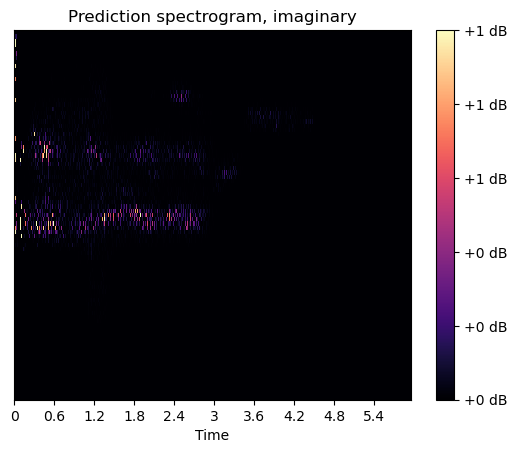

In [72]:
test_case(
    "short_clean.wav",
    "data/MS-SNSD/noise_test/AirConditioner_9.wav",
    unet_complex_2,
    "test_cases_2/test06"
)

*Most* of the air conditioner's white noise was removed, aligning with a general trend of better performance for noises of consistent frequencies. As compared to the single-epoch model, this model preserved slightly more of a signal frequency range.

## Training Histories

Each history is no more than three epochs large because of the size of our dataset; early stopping would trigger after, at the latest, the third pass through the dataset. Given more time, we could have created more focused datasets: as mentioned previously, it may be more productive to train "specializer" models, and attach a classifier that maps an audio sample to the denoiser best suited to handle it. This would also have given us smaller datasets, longer training runs (with regard to number of epochs), and a more clear pattern for the denoiser to learn.

In [73]:
import pickle

In [74]:
with open("histories/unet02", "rb") as file:
    unet02_history = pickle.load(file)

In [75]:
unet02_history

{'loss': [1.2280243635177612, 1.2226413488388062],
 'mse': [1.2137495279312134, 1.2083746194839478],
 'mae': [0.1595078706741333, 0.14200161397457123],
 'val_loss': [0.6687394976615906, 0.6690289974212646],
 'val_mse': [0.6684200167655945, 0.6687024831771851],
 'val_mae': [0.13023056089878082, 0.12920935451984406]}

In [76]:
with open("histories/unet10", "rb") as file:
    unet10_history = pickle.load(file)

In [77]:
unet10_history

{'loss': [1.2296983003616333, 1.2226980924606323],
 'mse': [1.2153842449188232, 1.2084301710128784],
 'mae': [0.16534894704818726, 0.14226804673671722],
 'val_loss': [0.6688573956489563, 0.6697914600372314],
 'val_mse': [0.6685383915901184, 0.6694546341896057],
 'val_mae': [0.1303303837776184, 0.12844020128250122]}

In [78]:
with open("histories/unet_complex", "rb") as file:
    unet_complex_history = pickle.load(file)

In [79]:
unet_complex_history

{'loss': [0.6753553748130798],
 'mse': [0.6683598756790161],
 'mae': [0.12190486490726471],
 'val_loss': [0.3839089870452881],
 'val_mse': [0.38367193937301636],
 'val_mae': [0.10714845359325409]}

In [80]:
with open("histories/unet_complex_2", "rb") as file:
    unet_complex_2_history = pickle.load(file)

In [81]:
unet_complex_2_history

{'loss': [0.6755942702293396, 0.6742966175079346, 0.674179196357727],
 'mse': [0.6686009764671326, 0.6673007011413574, 0.667180061340332],
 'mae': [0.12232305854558945, 0.11819645762443542, 0.11784519255161285],
 'val_loss': [0.38431626558303833, 0.38389158248901367, 0.38392528891563416],
 'val_mse': [0.38407066464424133, 0.3836514353752136, 0.383681982755661],
 'val_mae': [0.1069546714425087, 0.10695955902338028, 0.10650812089443207]}